In [1]:
using LightGraphs
using TikzGraphs, TikzPictures
using PyCall
include("MIGP.jl")

solve_MIGP (generic function with 2 methods)

# Visualize the branch and bound algorithm on a simple optimization problem

>$min$ $Z$

>$s.t.$ $Z \geq x_1 + x_2$
>>$6x_2 - 2x_3 \geq 10$

>>$4x_1 \geq 3x_3$

>>$2x_1 \geq x_2$

>>$x_i \geq 0, integer$  where $i\in$ {1,2,3}



In [2]:
from gpkit import Model, parse_variables, Vectorize, SignomialsEnabled, Variable, SignomialEquality, units

class Test1(Model):
    """ Test equation

    Variables
    ---------
    INT_x1                  [-]     x1
    INT_x2                  [-]     x2
    INT_x3                  [-]     x3
    Z                   [-]     Z

    """
    def setup(self):
        exec parse_variables(Test1.__doc__)
        ZERO = 1e-30
        x1 = INT_x1
        x2 = INT_x2
        x3 = INT_x3
        constraints = [Z >= x1+x2,
            6*x2 >= 10+ 2*x3,
            4*x1 >= 3*x3,
            2*x1 >= x2,
            x1 >= ZERO,
            x2 >= ZERO,
            x3 >= ZERO

        ]

        self.cost = Z

        return constraints

LoadError: syntax: extra token "gpkit" after end of expression

In [3]:
PyCall.pyversion
@pyimport mico_tests as mt

In [4]:
G = Graph()

{0, 0} undirected simple Int64 graph

In [5]:
mutable struct CostedNode
    vars::Array{String}
    vals::Array{Float64}
    vars_expanded::Array{String}
    best_vals::Array{Float64}
    cost::Float64
    level::Int16
    ID::Int16
    parentID::Int16
    label::String

end

In [6]:
function addNode!(Node, G, Node_List)
    add_vertex!(G)
    push!(Node_List,Node)
end

addNode! (generic function with 1 method)

## Solve Relaxed Problem

In [7]:
Node_List = CostedNode[]
var_names, values,cost  = mt.run_Test1(verbosity = 2)
N0 = CostedNode(var_names, values,[],[], cost, 1, 1, 0, "R")
addNode!(N0, G, Node_List)

plot(G,["R"],node_style="draw, rounded corners, fill=blue!10", options="scale=2, font=\\huge\\sf")

Using solver 'mosek'
Solving for 4 variables.
Number of Hessian non-zeros: 7
* Solving exponential optimization problem on dual form. *
* The following log information refers to the solution of the dual problem. *
Problem
  Name                   :                 
  Objective sense        : max             
  Type                   : GECO (general convex optimization problem)
  Constraints            : 5               
  Cones                  : 0               
  Scalar variables       : 10              
  Matrix variables       : 0               
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - n

In [8]:
dump(N0)

CostedNode
  vars: Array{String}((4,))
    1: String "Z_Test1"
    2: String "INT_x1_Test1"
    3: String "INT_x3_Test1"
    4: String "INT_x2_Test1"
  vals: Array{Float64}((4,)) [2.5, 0.833333, 1.0e-30, 1.66667]
  vars_expanded: Array{String}((0,))
  best_vals: Array{Float64}((0,)) Float64[]
  cost: Float64 2.4999999147791763
  level: Int16 1
  ID: Int16 1
  parentID: Int16 0
  label: String "R"


## Define some functions

In [9]:
function identify_INT_vars(vars, vals)
    
    #count int variables
    c = 0
    int_vars = String[]
    int_vals = Float64[]
    
    for (i,var) in enumerate(vars)
        key = split(var,"_")[1]
        if key == "INT"
            push!(int_vars,var)
            push!(int_vals,vals[i])
        end
    end
        return int_vars,int_vals
    end

identify_INT_vars (generic function with 1 method)

In [10]:
function nearest_ints(val)
    rounded = round(val)
    
    if rounded >= val
        return (rounded, rounded-1)
    else
        return (rounded+1,rounded)
    end
end

nearest_ints (generic function with 1 method)

In [11]:
function isInt(i)
   tol = 1e-3
    return min(i - floor(i), ceil(i)-i) < tol
end

isInt (generic function with 1 method)

In [12]:
function cleanup_input(varname::Array{String})
    output = String[]
    
    for str in varname
        trim = split(str, '.')[1]
        elem = split(trim, '_')
        s = ""
        for e in elem
            if e == "Test1"
                s = s[1:end-1]
                break
            else
                s = s*String(e)*'_'
            end
        end
        push!(output,s)
    end
    return output
end

cleanup_input (generic function with 2 methods)

In [13]:
function constrain_variable(Parent::CostedNode, G::Graph, constrained_vars, constrained_vals,g, 
        var2expand::String, current_best)
    
    if isInt(current_best)
        #findall(x->x==2, A)
        j = findall(x->x== var2expand,cleanup_input(Parent.vars))
        child_vars = copy(Parent.vars)
        child_vals = copy(Parent.vals)
        
        deleteat!(child_vars, j)
        deleteat!(child_vals, j)
        N = length(G.fadjlist)
        add_vertex!(G)
        l = var2expand*"="*string(round(current_best))
        best_child = CostedNode(child_vars, child_vals, 
            [Parent.vars_expanded...,var2expand],[Parent.best_vals...,current_best],
            Parent.cost,Parent.level+1, N+1, Parent.ID, l)
        
        add_edge!(G, Parent.ID, best_child.ID)
        worst_child = nothing
        
    else    
        (above, below) = nearest_ints(current_best)
        expanded = [Parent.vars_expanded..., var2expand]
        
        best_above = [Parent.best_vals..., above]
        best_below = [Parent.best_vals..., below]
        
        (vars_above, vals_above, cost_above) = g(expanded, best_above)
        (vars_below, vals_below, cost_below) = g(expanded, best_below)
        
        N = length(G.fadjlist)
        
        labove = var2expand*"="*string(above)
        Nabove = CostedNode(vars_above, vals_above,
            expanded,best_above,
            cost_above, Parent.level+1,N+1, Parent.ID, labove)
        
        lbelow = var2expand*"="*string(below)
        Nbelow = CostedNode(vars_above, vals_above,
            expanded,best_below,
            cost_above, Parent.level+1,N+2, Parent.ID, lbelow)
        
        add_vertex!(G)
        add_vertex!(G)
        add_edge!(G, Parent.ID, Nabove.ID)
        add_edge!(G, Parent.ID, Nbelow.ID)

        if cost_above == nothing && cost_below == nothing
            println("No feasible integer solution")
        elseif cost_above == nothing
            println("Likely infeasible above")
            best_val = below
            best_cost = cost_below[1]
            remaining_vars, remaining_values = identify_INT_vars(vars_below,vals_below)
            best_child = Nbelow
            worst_child = Nabove
        elseif cost_below == nothing
            println("Likely infeasible below")
            best_val = above
            best_cost = cost_above[1]
            remaining_vars, remaining_values = identify_INT_vars(vars_above,vals_above)
            best_child = Nabove
            worst_child = Nbelow

        elseif cost_above[1] <= cost_below[1]
            best_val = above
            best_cost = cost_above[1]
            remaining_vars, remaining_values = identify_INT_vars(vars_above,vals_above)
            best_child = Nabove
            worst_child = Nbelow

        else
            best_val = below
            best_cost = cost_below[1]
            remaining_vars, remaining_values = identify_INT_vars(vars_below,vals_below)
            best_child = Nbelow
            worst_child = Nabove
        end
    end
    
    return (best_child, worst_child)
    
end




constrain_variable (generic function with 1 method)

In [14]:
Int_Vars, Int_Vals = identify_INT_vars(cleanup_input(N0.vars),N0.vals)
cols = fill("fill=red!10",2*length(Int_Vars)+1)
cols[1] = "fill=blue!10"

function expand!(ParentNode,Graph, Int_Vars, Int_Vals,g)
    
    current_rank = ParentNode.level    #Identify current level of the tree (which keys the variable to expand)
    child_rank = current_rank+1 #Put all children one level below
    Nvars = length(Int_Vars)
    #i = current_rank  #Determine the variable which gets expanded based on the rank
    var2expand   = Int_Vars[1]
    val2expand   = Int_Vals[1]
    
    (best_child, worst_child) = constrain_variable(ParentNode, Graph, Int_Vars, Int_Vals,g, 
        var2expand, val2expand)
    
end


expand! (generic function with 1 method)

In [15]:
function drawgraph(G, Node_List, cols)
    labels = fill("", length(Node_List))
    node_styles=Dict()
    for Node in Node_List
        e = split(Node.label, '_')
        labels[Node.ID] = e[min(2,length(e))]
    end
    for (i,col) in enumerate(cols[1:length(Node_List)])
        node_styles[i] =col
    end
    plot(G, labels,node_style="draw, rounded corners, fill=blue!10", node_styles=node_styles,
        options="scale=2, font=\\huge\\sf")
end

drawgraph (generic function with 1 method)

## Constrain the first integer variable

In [16]:
g(vars, vals) = mt.run_Test1(vars, vals)

g (generic function with 1 method)

In [17]:
(Parent, Pruned) = expand!(N0, G, Int_Vars, Int_Vals, g)
push!(Node_List, Parent)
push!(Node_List, Parent)
Node_List[Pruned.ID] = Pruned
cols[Parent.ID] = "fill=blue!10"


Likely infeasible below
Likely infeasible model at ['INT_x1']
 [0.]


"fill=blue!10"

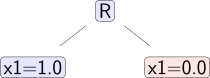

In [18]:
drawgraph(G, Node_List, cols)

## Expand subsequent nodes

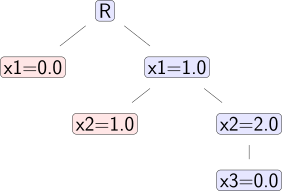

In [69]:
Int_Vars, Int_Vals = identify_INT_vars(cleanup_input(Parent.vars),Parent.vals)
(Parent, Pruned) = expand!(Parent, G, Int_Vars, Int_Vals, g)
if Parent != nothing
    cols[Parent.ID] = "fill=blue!10"
    push!(Node_List, Parent)
else
    println("No valid integer solution")
end
    
if Pruned != nothing
    push!(Node_List, Parent)
    Node_List[Pruned.ID] = Pruned
end
drawgraph(G, Node_List, cols)

# Compare Timing With JuMP

In [20]:
using JuMP
using Mosek

In [26]:
m = Model(solver = MosekSolver())
@variable(m, 0 <= x1 <= Inf,Int)
@variable(m, 0 <= x2 <= Inf,Int)
@variable(m, 0 <= x3 <= Inf,Int)
@variable(m, 0 <= Z <= Inf)

@objective(m, Min, Z )
@constraint(m, x1+x2 <= Z )
@constraint(m, 10 + 2x3 <= 6x2 )
@constraint(m, 4x1 >= 3x3 )
@constraint(m, 2x1 >= x2 )

print(m)

JuMP_Time = @elapsed status = solve(m)

println("Objective value: ", getobjectivevalue(m))
println("x1 = ", getvalue(x1))
println("x2 = ", getvalue(x2))
println("x3 = ", getvalue(x3))

Min Z
Subject to
 x1 + x2 - Z ≤ 0
 2 x3 - 6 x2 ≤ -10
 4 x1 - 3 x3 ≥ 0
 2 x1 - x2 ≥ 0
 x1 ≥ 0, integer
 x2 ≥ 0, integer
 x3 ≥ 0, integer
 Z ≥ 0
Problem
  Name                   :                 
  Objective sense        : min             
  Type                   : LO (linear optimization problem)
  Constraints            : 4               
  Cones                  : 0               
  Scalar variables       : 4               
  Matrix variables       : 0               
  Integer variables      : 3               

Optimizer started.
Mixed integer optimizer started.
Threads used: 4
Presolve started.
Presolve terminated. Time = 0.00
Presolved problem: 0 variables, 0 constraints, 0 non-zeros
Presolved problem: 0 general integer, 0 binary, 0 continuous
Clique table size: 0
BRANCHES RELAXS   ACT_NDS  DEPTH    BEST_INT_OBJ         BEST_RELAX_OBJ       REL_GAP(%)  TIME  
0        1        0        0        3.0000000000e+00     3.0000000000e+00     0.00e+00    0.0   
An optimal solution satisf

In [37]:
include("MIGP.jl")
@pyimport runGP

In [61]:
#Some output printing

function print_val(var_name, var_list, value_list)
    i = findfirst(x->occursin(var_name,x), var_list)
    println(var_name*": "*string(value_list[i]))
end

print_val (generic function with 1 method)

In [67]:
pkg_name = "mico_tests"
mod_name = "Test1"
GP_Time = @elapsed out = solve_MIGP(runGP.run_GP, pkg_name, mod_name)

print_val("x1", out[1], out[2])
print_val("x2", out[1], out[2])
print_val("x3", out[1], out[2])

x1: 1.0
x2: 2.0
x3: 1.0000000000000024e-30
Likely infeasible model at ['INT_x2']
 [1.]
Likely infeasible model at ['INT_x2', 'INT_x3', 'INT_x1']
 [2.e+00 1.e-30 1.e-15]


Note that because geometric programming constraints are only convex under a logarithmic change of variables, zero is not a valid integer value, since log(0) = -$\infty$.  Therefore, zero is replaced with a small positive number (10^-30), which has the same practical effect.  

For more on how geometric programming constraints are solved, see https://docs.mosek.com/modeling-cookbook/expo.html#geometric-programming.

In [68]:
@show JuMP_Time
@show GP_Time

JuMP_Time = 0.001681676
GP_Time = 0.129456586


0.129456586

## If you can use JuMP (or linear programming) - you should!

Solving this problem using a dedicated MILP solver is significantly faster.  However, we are interested in a class of problems not representably as a LP, or currently supported by JuMP. 